In [1]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [4]:
# define constants and other parameters
K = 1e-7 # erodibility
beta = 0.0005 # abradability
r = 5. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.375 # fraction plucked that becomes coarse
theta = 0.375 # fraction hillslope that enters as coarse
# treat as same!!! Point is what fraction becomes coarse
# so just be sure to change these together

kqs = 0.041 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [5]:
def model(x, dx, x_node,
          K, beta, gamma, theta,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 50
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * gamma
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * theta)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - Eb_p[:-1] - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [6]:
#now write a test
num_steps = 1000000

test_run = [x, dx, x_node, 
            K, beta, gamma, theta,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

50000000.0


In [7]:
Eb

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 0.e+00])

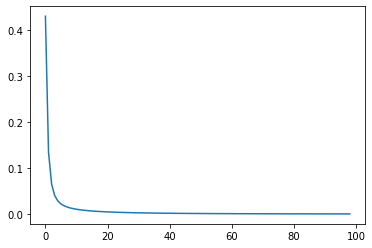

In [8]:
plt.plot(S)

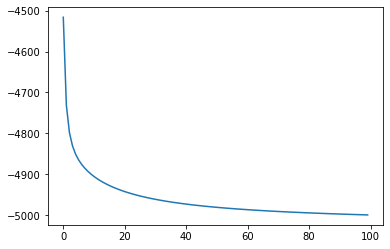

In [9]:
plt.plot(eta)

In [10]:
S[-1]

0.0004402111710005556

In [11]:
eta

array([-4516.06052343, -4731.15294587, -4798.24710199, -4830.7710126 ,
       -4850.79099166, -4865.03397503, -4876.09233026, -4885.15529013,
       -4892.84783501, -4899.53468867, -4905.44669128, -4910.73956457,
       -4915.5238318 , -4919.88121841, -4923.87420698, -4927.55189589,
       -4930.95375105, -4934.11210021, -4937.05384641, -4939.80167903,
       -4942.374952  , -4944.79033498, -4947.06230609, -4949.2035315 ,
       -4951.22516255, -4953.13707185, -4954.94804312, -4956.66592579,
       -4958.29776222, -4959.84989328, -4961.32804679, -4962.73741223,
       -4964.08270415, -4965.36821644, -4966.59786907, -4967.77524841,
       -4968.90364237, -4969.98607098, -4971.02531325, -4972.02393074,
       -4972.98428847, -4973.90857328, -4974.79881026, -4975.65687737,
       -4976.48451839, -4977.28335466, -4978.0548955 , -4978.80054765,
       -4979.52162369, -4980.21934976, -4980.89487244, -4981.54926501,
       -4982.18353318, -4982.79862021, -4983.39541166, -4983.97473966,
      

In [12]:
eta_adj = eta - eta[-1]

In [13]:
eta_adj

array([4.83339477e+02, 2.68247054e+02, 2.01152898e+02, 1.68628987e+02,
       1.48609008e+02, 1.34366025e+02, 1.23307670e+02, 1.14244710e+02,
       1.06552165e+02, 9.98653114e+01, 9.39533088e+01, 8.86604355e+01,
       8.38761683e+01, 7.95187817e+01, 7.55257931e+01, 7.18481042e+01,
       6.84462490e+01, 6.52878999e+01, 6.23461537e+01, 5.95983211e+01,
       5.70250481e+01, 5.46096651e+01, 5.23376940e+01, 5.01964686e+01,
       4.81748375e+01, 4.62629282e+01, 4.44519570e+01, 4.27340743e+01,
       4.11022379e+01, 3.95501068e+01, 3.80719533e+01, 3.66625879e+01,
       3.53172959e+01, 3.40317836e+01, 3.28021310e+01, 3.16247517e+01,
       3.04963577e+01, 2.94139291e+01, 2.83746868e+01, 2.73760693e+01,
       2.64157116e+01, 2.54914268e+01, 2.46011898e+01, 2.37431227e+01,
       2.29154817e+01, 2.21166454e+01, 2.13451046e+01, 2.05994524e+01,
       1.98783764e+01, 1.91806503e+01, 1.85051277e+01, 1.78507351e+01,
       1.72164669e+01, 1.66013799e+01, 1.60045884e+01, 1.54252604e+01,
      

In [14]:
# save csv files

np.savetxt('elevation csv files/eta_exp_14.csv', eta_adj, delimiter = ',')
np.savetxt('alpha csv files/alpha_exp_14.csv', alpha, delimiter = ',')